<a href="https://colab.research.google.com/github/Modak12/GestureControl/blob/main/Neural_Nets_Manisha_Jayshree-new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [184]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [185]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

In [188]:
print(len(train_doc))
print(len(val_doc))

663
100


In [189]:
# trying model with 50 datasets now

train_doc = list(train_doc)[:50]
val_doc = list(val_doc)[:10]
batch_size = 10

In [190]:
dimension={
    'img_idx' : [x for x in range(30)],
    'y' : 120,
    'z' : 120
}

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [191]:
def generator(source_path, folder_list, batch_size, dimensions=dimension):

    print( 'Source path = ', source_path, '; batch size =', batch_size)

    img_idx = dimensions['img_idx']
    x = len(img_idx)
    y = dimensions['y']
    z = dimensions['z']

    while True:

        t = np.random.permutation(folder_list)
        num_batches = len(train_doc)//batch_size # calculate the number of batches
        print("Number of batches : ",num_batches)

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = resize(image,(y,z))
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255.0 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if(len(t) % batch_size):
          rem_batches = len(t) % batch_size
          print("Remaining batches : ",rem_batches)
          rem_batch_data = np.zeros((rem_batches,x,y,z,3))
          batch_labels = np.zeros((rem_batches,5))
          for folder in range(rem_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*rem_batches)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*rem_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = resize(image,(y,z))
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    rem_batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    rem_batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    rem_batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*rem_batches)].strip().split(';')[2])] = 1
          yield rem_batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [192]:
curr_dt_time = datetime.datetime.now()

train_path = '/content/drive/My Drive/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 1 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 50
# validation sequences = 10
# epochs = 1


In [193]:
# testing generative
test_gen = generator(train_path, train_doc, 1)
d = next(test_gen)[0]

Source path =  /content/drive/My Drive/Project_data/train ; batch size = 1
Number of batches :  50


<ipython-input-191-7764a8e080dd>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [194]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import ConvLSTM2D
from keras import optimizers
from tensorflow.keras.optimizers import Adam

sample_shape = (30, 120, 120, 3)
no_classes = 5

### 1.Conv 3D

Experiment 1

In [195]:
# Simple 3DConv Model

# Conv3D -> Accuracy: 0.18 -> Simple Conv3D model

In [196]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

Experiment 2

In [197]:
#  3DConv Model with kernel size 5

# Conv3D -> Accuracy: 0.28 -> 3DConv Model with kernel size 5, Improvement in accuracy

In [198]:
# model = Sequential()

# model.add(Conv3D(16, kernel_size=(5, 5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(no_classes, activation='softmax'))


Experiment 3

In [199]:
#  3DConv Model with kernel size 3

# Conv3D -> Accuracy: 0.10 -> 3DConv Model with kernel size 3, accuracy dropped

In [200]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(no_classes, activation='softmax'))


Experiment 4

In [201]:
#  3DConv Model with kernel size 5 and decresed poolsize

# Conv3D -> Accuracy: 0.26 -> 3DConv Model with kernel size 5, accuracy increased.

In [202]:
# model = Sequential()

# model.add(Conv3D(16, kernel_size=(5, 5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(no_classes, activation='softmax'))

Experiment 5

In [203]:
#  3DConv Model with kernel size 5 and increased layer

# Conv3D -> Accuracy: 0.18 -> accuracy dropped to 0.18 again

In [204]:
# model = Sequential()

# model.add(Conv3D(16, kernel_size=(5, 5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(128, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(no_classes, activation='softmax'))

Experiment 6

In [205]:
#  3DConv Model with kernel size 5 and different dropouts

# Conv3D -> Accuracy: 0.26 -> accuracy restored to 0.26 again

In [206]:
# model = Sequential()

# model.add(Conv3D(16, kernel_size=(5, 5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# BatchNormalization()

# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.25)

# model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
# BatchNormalization(),
# Dropout(0.50)

# model.add(Dense(no_classes, activation='softmax'))

### Experiment 7
 Conv2D + RNN

In [207]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=sample_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))


#### Experiment 8
CONV2D+GRU
Experimenting by changed layers

In [208]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=sample_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

### Experiment 9
CONV 2D+LSTM

In [ ]:
#model = Sequential()
#model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=sample_shape))
#model.add(BatchNormalization())
#model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
#model.add(BatchNormalization())

#model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
#model.add(BatchNormalization())
#model.add(TimeDistributed(Dense(64, activation='relu')))
#model.add(BatchNormalization())

#model.add(GlobalAveragePooling2D())
#model.add(Dense(64, activation='relu'))
#model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [209]:
optimiser = Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeD  (None, 30, 118, 118, 32   896       
 istributed)                 )                                   
                                                                 
 time_distributed_29 (TimeD  (None, 30, 59, 59, 32)    0         
 istributed)                                                     
                                                                 
 batch_normalization_18 (Ba  (None, 30, 59, 59, 32)    128       
 tchNormalization)                                               
                                                                 
 time_distributed_30 (TimeD  (None, 30, 57, 57, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, 30, 28, 28, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [210]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [211]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [212]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [213]:
# num_epochs = 10

In [214]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-214-40acd7b7729e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-191-7764a8e080dd>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /content/drive/My Drive/Project_data/train ; batch size = 10
Number of batches :  5
5/5 [==============================] - ETA: 0s - loss: 1.9457 - categorical_accuracy: 0.3200 Source path =  /content/drive/My Drive/Project_data/val ; batch size = 10
Number of batches :  5



Epoch 1: saving model to model_init_2024-03-2304_35_26.802843/model-00001-1.94573-0.32000-1.62759-0.10000.h5
5/5 [==============================] - 77s 15s/step - loss: 1.9457 - categorical_accuracy: 0.3200 - val_loss: 1.6276 - val_categorical_accuracy: 0.1000 - lr: 0.0010


In [215]:
history.history

{'loss': [1.9457287788391113],
 'categorical_accuracy': [0.3199999928474426],
 'val_loss': [1.6275936365127563],
 'val_categorical_accuracy': [0.10000000149011612],
 'lr': [0.001]}

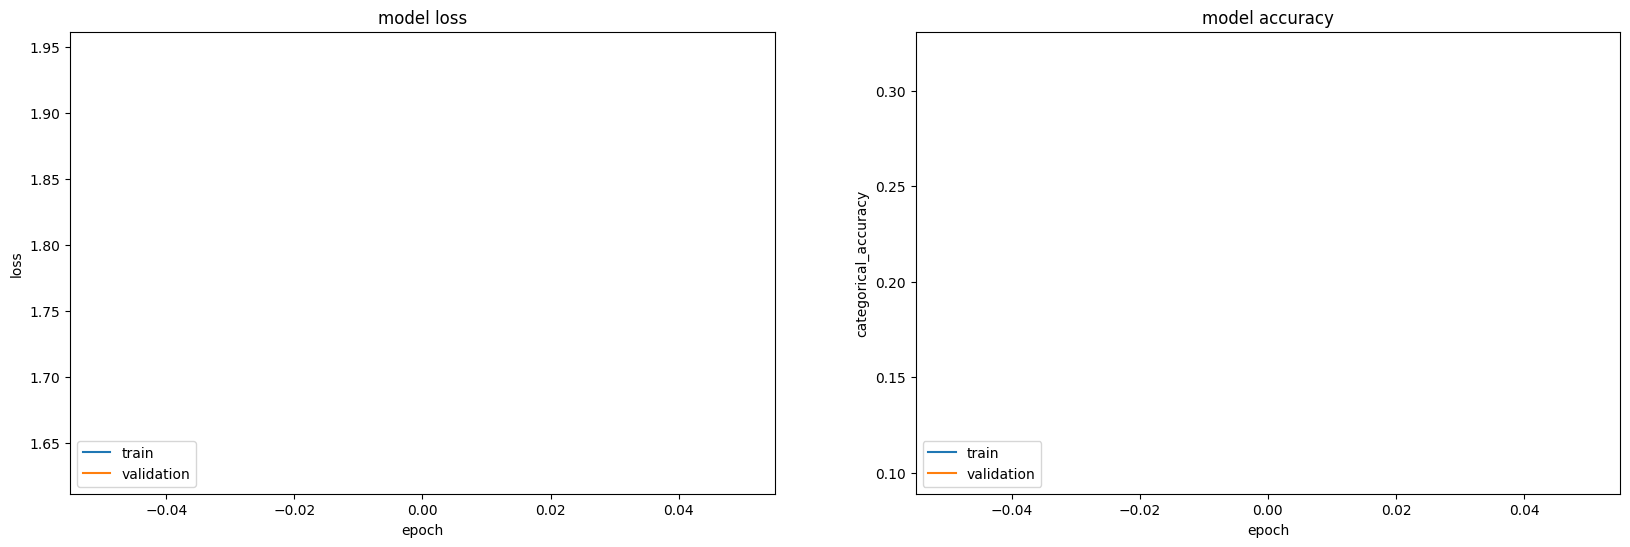

In [216]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')